In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from zoneinfo import ZoneInfo
import numpy as np
import pysolar
import time
from datetime import datetime, timedelta
from dataclasses import dataclass
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import os

In [3]:
import pylab

pylab.rcParams['figure.figsize'] = (9.0, 6.0)

In [4]:
import FreeCAD

In [5]:
import FreeCADGui as Gui

In [6]:
Gui.showMainWindow()

In [7]:
FreeCAD.openDocument(str(Path(os.getcwd()) / 'garage-panel-link.FCStd'))

<Document object at 0000018903244460>

In [8]:
av = Gui.activeDocument().activeView()

In [9]:
cam = Gui.ActiveDocument.ActiveView.getCameraNode()
cam.position.setValue(coin.SbVec3f(1876.2856, 22110.605, 24844.164))
cam.orientation.setValue(coin.SbVec3f( -1.6727624e-008, 0.38268346, 0.92387962), 3.1415927)
cam.nearDistance.setValue(-26140.619)
cam.farDistance.setValue(83344.258)
cam.aspectRatio.setValue(1)
cam.focalDistance.setValue(33327.754)
cam.height.setValue(9908.3027)

In [10]:
@dataclass
class Panel:
    name: str
    lower: np.ndarray
    upper: np.ndarray
    color_name: str

Filter parameters to find panels based on color

In [11]:
filters = [
    Panel('001', np.array([0, 200, 0]), np.array([10, 255, 255]), 'red'),
    Panel('002', np.array([45, 200, 0]), np.array([55, 255, 255]), 'green'),
    Panel('003', np.array([95, 150, 0]), np.array([105, 255, 255]), 'blue'),
    Panel('004', np.array([145, 100, 0]), np.array([155, 255, 255]), 'magenta'),
]

Find pixels belonging to a certain panel

In [12]:
def find_pixels_for_border(frame_hsv, frame_gray, lower_limit, upper_limit, percentile):
    mask = cv2.inRange(frame_hsv, lower_limit, upper_limit)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    hull = np.zeros(mask.shape, np.uint8)
    hull = cv2.drawContours(hull, np.array([np.squeeze(cv2.convexHull(np.concatenate(contours)))]), -1, 255, cv2.FILLED)

    idx = (hull == 255) & (mask == 0)
    x1 = frame_gray[idx]
    p = np.percentile(x1, percentile)
    idx &= (frame_gray >= p)
    return idx

In [13]:
def get_frames(file_name):
    inputImage = cv2.imread(file_name)
    frame_hsv = cv2.cvtColor(inputImage, cv2.COLOR_BGR2HSV)
    gray_image = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    return frame_hsv, gray_image


Compare panel pixel gray values with limit based on panel without shadow to 
consider radiation power depending on elevation. This assumes that the 
panel without shadow is always illuminated from the front which is not true. 
However, illumination from the back will be filtered out using 
Lambert's cosine law below the effect is ignored here.

In [14]:
def calc_shadow_ratio(panel_filter, file_name_base, frame_hsv, frame_gray):
    # print(panel_filter.name)
    # Get images of panel alone, so no shadow on it. Could only be
    # illuminated from the back but this is ignored here.
    frame_hsv_p, frame_gray_p = get_frames(
        f'{file_name_base}{panel_filter.name}.png'
    )

    idx_p = find_pixels_for_border(
        frame_hsv_p, frame_gray_p, panel_filter.lower, panel_filter.upper, 10
    )
    f = np.zeros(frame_gray_p.shape, np.uint8)
    f[idx_p] = frame_gray_p[idx_p]

    x1 = frame_gray_p[idx_p]
    # Lower limit value for panel pixel without shadow
    lim = 0.99 * np.min(x1)
    # print(f'min: {np.min(x1)}, max: {np.max(x1)}')
    # print(f'limit: {lim}')

    idx = find_pixels_for_border(
        frame_hsv, frame_gray, panel_filter.lower, panel_filter.upper, 2
    )
    x2 = frame_gray[idx]
    final = np.zeros(frame_gray.shape, np.uint8)
    final[idx] = x2
    # plt.imshow(final, vmin=0, vmax=255)
    # plt.show()

    counts, bins = np.histogram(x2, bins=256, range=[0, 255])

    # print(f'#pixels: {len(x2)}')
    # print(f'#shadow: {np.sum(x2 < lim)}')
    # print(f'shadow: {np.sum(x2 < lim)/len(x2)}')

    # plt.stairs(counts, bins)
    # plt.show()
    # return ratio of panel pixels with shadow to all pixels
    return np.sum(x2 < lim)/len(x2)

Vector of incoming solar rays

In [15]:
def light_vector(date, latitude, longitude):
    altitude = pysolar.solar.get_altitude(latitude, longitude, date)
    alpha = np.radians(pysolar.solar.get_azimuth(latitude, longitude, date))
    beta = -np.radians(altitude)
    if beta > 0:
        return (0, 0, 0), 0, True

    x = np.sin(alpha)*np.cos(beta)
    y = np.cos(alpha)*np.cos(beta)
    z = np.sin(beta)
    p = pysolar.solar.radiation.get_radiation_direct(date, altitude)
    return (x, y, z), p, False

Normal vector of solar panel by finding the largest upward orientated surface

In [16]:
def find_panel_normal(faces):
    a_max = 0
    for f in faces:
        if f.Area > a_max and f.normalAt(0, 0)[2] > 0:
            a_max = f.Area
            normal = f.normalAt(0, 0)
    return normal

In [17]:
latitude = 48.0
longitude = 11

day = 1
month = 1

panel_group_name = 'PanelL'
buildings = FreeCAD.ActiveDocument.getObjectsByLabel('Buildings')[0]
panel_group = FreeCAD.ActiveDocument.getObjectsByLabel(f'Solar{panel_group_name}')[0]
label = FreeCAD.ActiveDocument.getObjectsByLabel('DateLabel')[0]

file_name_base = Path(os.getcwd()) / Path(f'out/{panel_group_name}')

In [18]:
file_name_base.parent.mkdir(exist_ok=True, parents=True)

In [19]:
%%time
out = []
for dd in range(0, 365, 28):
    print(dd)
    for h in range(0, 24, 2):
        for m in range(0, 60, 60):
            date = datetime(2025, month, day, h, m, 0, 0, tzinfo=ZoneInfo('Europe/Paris')) + timedelta(days=dd)
            label.LabelText = date.isoformat()
            Gui.updateGui()

            (x, y, z), solar_p, skip = light_vector(date, latitude, longitude)
            if skip > 0:
                continue

            buildings.ViewObject.Visibility = True
            panel_group.ViewObject.Visibility = True
            # time.sleep(0.2)
            Gui.updateGui()
            av.Shadow_LightDirection = (x, y, z)
            time.sleep(0.1)
            Gui.updateGui()
            label.ViewObject.Visibility = True
            Gui.updateGui()
            Gui.activeDocument().activeView().saveImage(f'{file_name_base}_{date.strftime("%Y%m%d_%H%M")}.png', 1280, 720, 'Current')
            Gui.activeDocument().activeView().saveImage(f'{file_name_base}.png', 1280, 720, 'Current')
            # time.sleep(0.5)

            buildings.ViewObject.Visibility = False
            panel_group.ViewObject.Visibility = False
            solar_vector = -np.array([x, y, z])
            Gui.updateGui()
            frame_hsv, gray_image = get_frames(f'{file_name_base}.png')
            out_row = {
                'time': date.isoformat(),
                'solar_power': solar_p
            }
            for f in filters:
                panel_name = f'{panel_group_name}{f.name}'
                panel_file_name = f'{file_name_base}{f.name}'
                panel = FreeCAD.ActiveDocument.getObjectsByLabel(panel_name)[0]
                fv = find_panel_normal(panel.Shape.Faces)
                lamb = np.dot(fv, solar_vector)/np.linalg.norm(fv)/np.linalg.norm(solar_vector)
                panel.ViewObject.Visibility = True
                Gui.updateGui()
                Gui.activeDocument().activeView().saveImage(f'{panel_file_name}.png', 1280, 720, 'Current')
                FreeCAD.ActiveDocument.getObjectsByLabel(panel_name)[0].ViewObject.Visibility = False
                Gui.updateGui()
                sr = calc_shadow_ratio(f, file_name_base, frame_hsv, gray_image)
                out_row[f'view_factor_{f.name}'] = lamb
                out_row[f'shadow_ratio_{f.name}'] = sr
            out.append(out_row)
df = pd.DataFrame(out)

In [20]:
df.time = pd.to_datetime(df.time, utc=True)

In [21]:
df2 = df.copy()
# needed to be able to export to Excel
df2['time'] = df2['time'].dt.tz_localize(None)
df2.to_excel(f'{file_name_base}_analysis.xlsx')

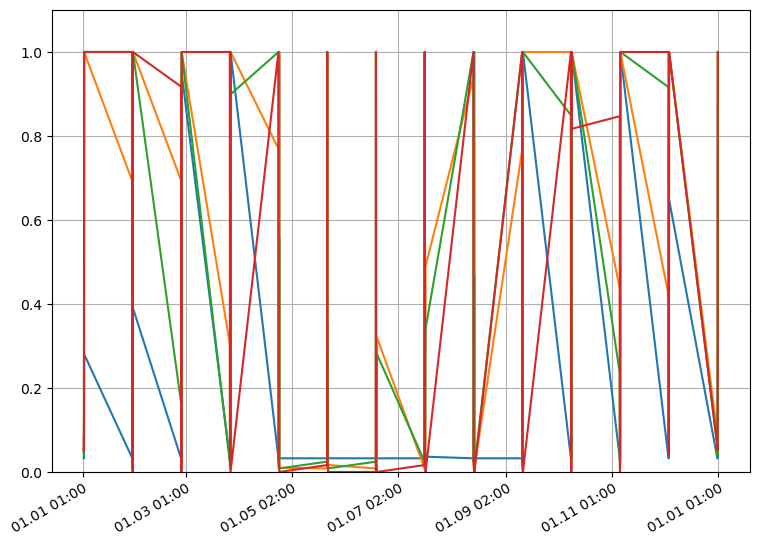

In [22]:
plt.plot(df.time.values, df.shadow_ratio_001.values)
plt.plot(df.time.values, df.shadow_ratio_002.values)
plt.plot(df.time.values, df.shadow_ratio_003.values)
plt.plot(df.time.values, df.shadow_ratio_004.values)
myFmt = mdates.DateFormatter('%d.%m %H:%M', tz=ZoneInfo('Europe/Paris'))
plt.gca().xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()